In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.model_selection import train_test_split
import re, requests, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 10]
%config InlineBackend.figure_format = 'retina'

In [2]:
request = requests.get('https://www.euribordiario.es/flash/euribor12y.php')

In [3]:
if request:

    content = request.content.decode('utf-8')
    raw_data = re.findall("values\_?\d{0,2}\=(.*?)\&", content)
 
    count_year = datetime.datetime.now().year
    month = datetime.datetime.now().month
    day = datetime.datetime.now().day

    if month == 1 or (month == 2 and day == 2):
        count_year -= 1

    final_array = {}

    for line in reversed(raw_data):
        floats_line = [float(x) for x in line.split(",")]
        final_array[count_year] = floats_line
        count_year = count_year - 1

    months_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    euribor_df = pd.DataFrame.from_dict(final_array, orient='index', columns=months_name).fillna(0).sort_index()

else:
    print('An error has occurred.')

In [4]:
euribor_df.shape

(12, 12)

In [5]:
euribor_df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2011,1.550,1.714,1.924,2.086,2.147,2.144,2.183,2.097,2.067,2.110,2.044,2.004
2012,1.837,1.678,1.499,1.368,1.266,1.219,1.061,0.877,0.740,0.650,0.588,0.549
2013,0.575,0.594,0.545,0.528,0.484,0.507,0.525,0.542,0.543,0.541,0.506,0.543
2014,0.562,0.549,0.577,0.604,0.592,0.513,0.488,0.469,0.362,0.338,0.335,0.329
2015,0.298,0.255,0.212,0.180,0.165,0.163,0.167,0.161,0.154,0.128,0.080,0.059
2016,0.042,-0.008,-0.012,-0.010,-0.013,-0.028,-0.056,-0.048,-0.057,-0.069,-0.074,-0.080
2017,-0.095,-0.106,-0.110,-0.119,-0.127,-0.149,-0.154,-0.156,-0.168,-0.180,-0.189,-0.190
2018,-0.189,-0.191,-0.191,-0.190,-0.188,-0.181,-0.180,-0.169,-0.166,-0.154,-0.147,-0.129
2019,-0.116,-0.108,-0.109,-0.112,-0.134,-0.190,-0.283,-0.356,-0.339,-0.304,-0.272,-0.261
2020,-0.253,-0.288,-0.266,-0.108,-0.081,-0.147,-0.279,-0.359,-0.415,-0.466,-0.481,-0.497


In [6]:
euribor_df.to_csv('euribor_historical.csv', index=True)

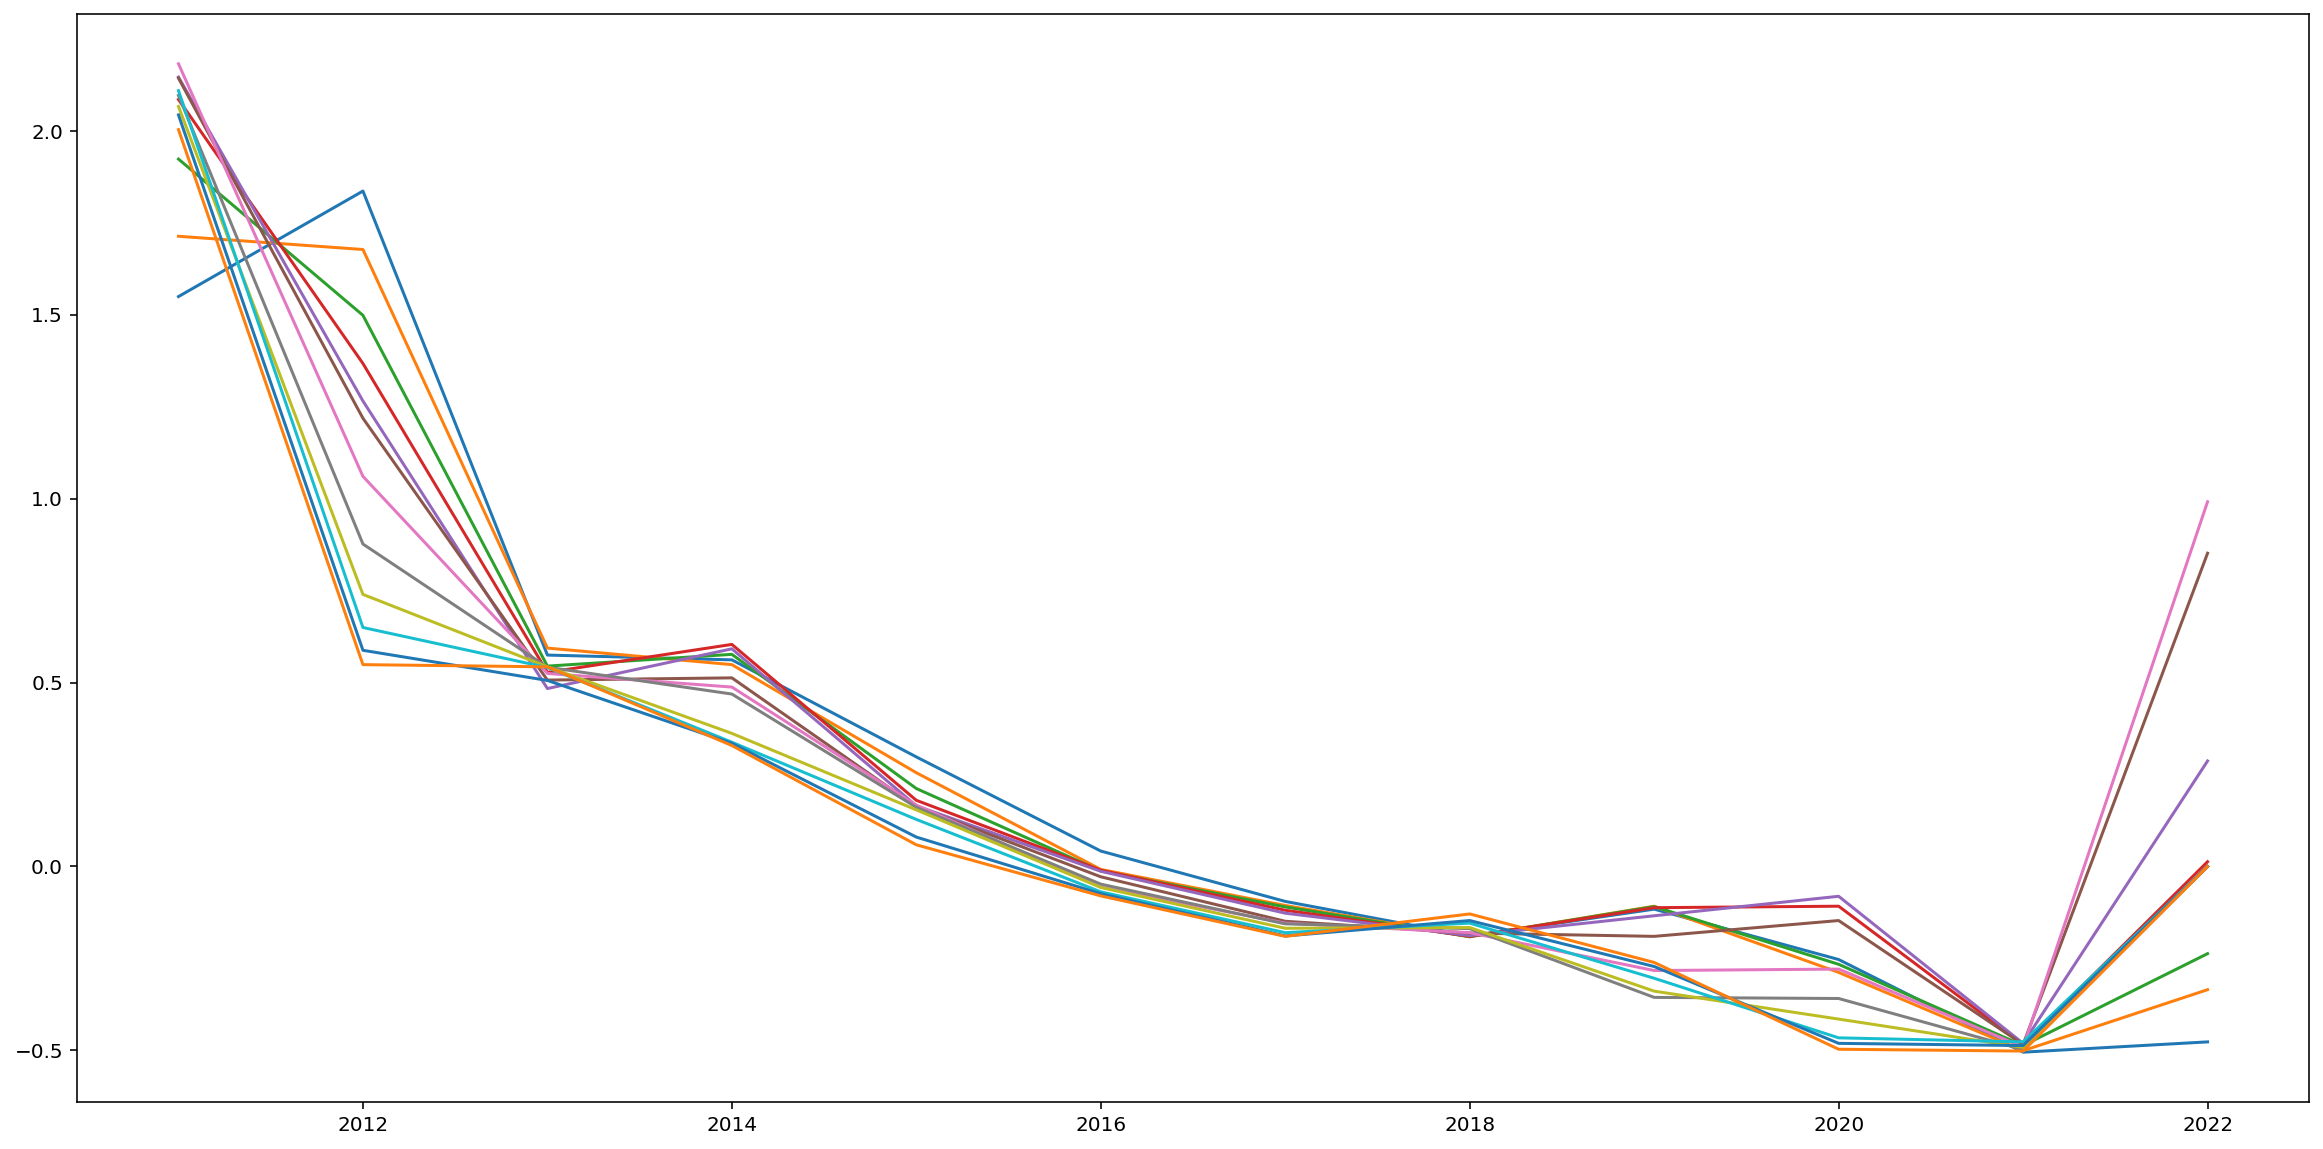

In [7]:
plt.plot(euribor_df)
plt.show()

In [8]:
indexes = euribor_df.index.tolist()

In [9]:
cols = ['date','euribor']
df_rework = pd.DataFrame(columns=cols)
df_rework.set_index('date')

for index in indexes:
    yearly_values = euribor_df.loc[[index]].values.flatten()
    
    month = 1
    for value in yearly_values:
        date = "%s-%02d" % (str(index), month)
        #date = datetime.datetime.strptime(date, '%Y-%m')
     
        month += 1
        
        new_data = {'date': date, 'euribor': value}
        df_rework = df_rework.append(new_data, ignore_index=True)

In [10]:
df_rework.head()

,date,euribor
0,2011-01,1.550
1,2011-02,1.714
2,2011-03,1.924
3,2011-04,2.086
4,2011-05,2.147


In [11]:
df_rework.dtypes

date        object
euribor    float64
dtype: object

In [12]:
df_rework.to_csv('euribor_historical_rework.csv', index=True)

In [13]:
df_rework.drop(['date'], 1, inplace=True)

In [14]:
df_rework.head()

,euribor
0,1.550
1,1.714
2,1.924
3,2.086
4,2.147


In [15]:
prediction_days = 30

df_train = df_rework[:len(df_rework) - prediction_days]
df_test = df_rework[len(df_rework) - prediction_days:]

In [16]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [17]:
training_set = df_train.values
training_set = min_max_scaler.fit_transform(training_set)

x_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [18]:
model = Sequential()

model.add(LSTM(units = 4, activation = 'sigmoid', input_shape=(None, 1)))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(x_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
23/23 [==============================] - 15s 975us/step - loss: 0.3867
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 0.3629
Epoch 3/100
23/23 [==============================] - 0s 947us/step - loss: 0.3232
Epoch 4/100
23/23 [==============================] - 0s 909us/step - loss: 0.2828
Epoch 5/100
23/23 [==============================] - 0s 910us/step - loss: 0.1857
Epoch 6/100
23/23 [==============================] - 0s 818us/step - loss: 0.1740
Epoch 7/100
23/23 [==============================] - 0s 864us/step - loss: 0.1557
Epoch 8/100
23/23 [==============================] - 0s 864us/step - loss: 0.1138
Epoch 9/100
23/23 [==============================] - 0s 863us/step - loss: 0.1053
Epoch 10/100
23/23 [==============================] - 0s 864us/step - loss: 0.0982
Epoch 11/100
23/23 [==============================] - 0s 864us/step - loss: 0.1183
Epoch 12/100
23/23 [==============================] - 0s 818us/step - loss: 0.1125
Epoch 13/100
2

In [21]:
test_set = df_test.values

inputs = np.reshape(test_set, (len(test_set), 1))
inputs = min_max_scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_price = model.predict(inputs)
predicted_price = min_max_scaler.inverse_transform(predicted_price)

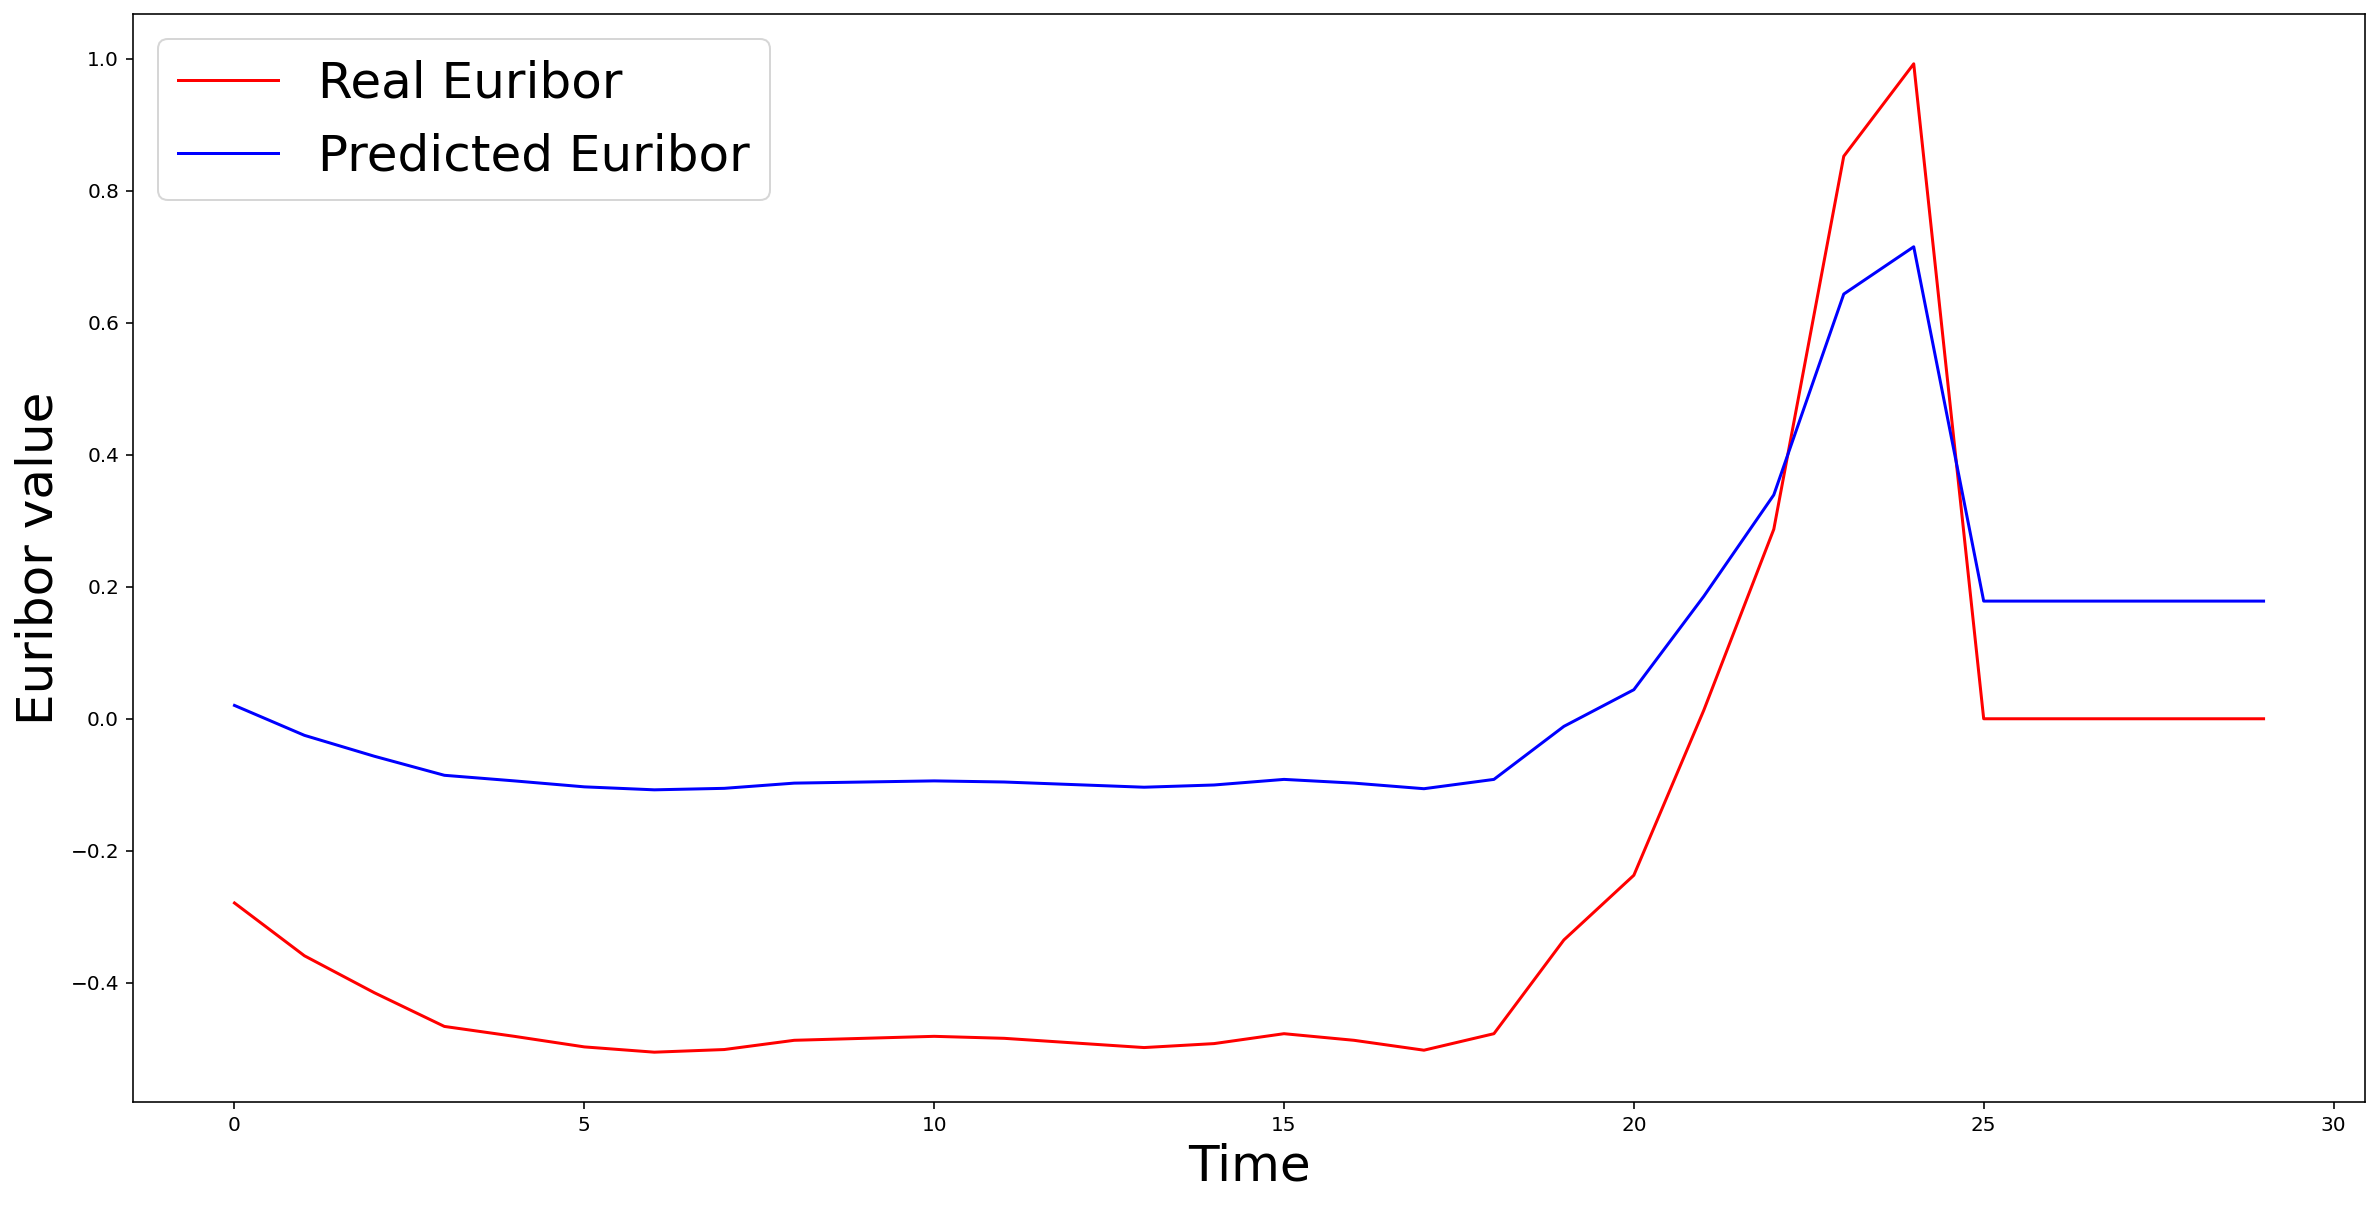

In [28]:
plt.plot(test_set[:, 0], color='red', label='Real Euribor')
plt.plot(predicted_price[:, 0], color = 'blue', label = 'Predicted Euribor')

plt.xlabel('Time', fontsize=25)
plt.ylabel('Euribor value', fontsize = 25)
plt.legend(loc = 'best', fontsize = 25)
plt.show()